# Best model

In [1]:
import pandas as pd
import scanpy as sc
import openai
import time
import numpy as np

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import lightning as L

import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [ ]:
df_deepsy = pd.read_csv("/gpfs/gibbs/pi/zhao/tl688/synergy_prediction/predictions_result_synergy.csv")

df_grountruth_score = pd.read_csv("/gpfs/gibbs/pi/zhao/tl688/synergy_prediction/labels_synergy_value.csv")

import pickle

with open("/gpfs/gibbs/pi/zhao/tl688/DeepDDs/ensem_emb_celllinedrugleave.pickle", 'rb') as f:
    cellline_name_getembedding = pickle.load(f)
with open("/gpfs/gibbs/pi/zhao/tl688/DeepDDs/ensem_emb_alldrugleave.pickle", 'rb') as f:
    drug_name_getembedding = pickle.load(f)

In [5]:
data_test = pd.read_csv(f"/gpfs/gibbs/pi/zhao/tl688/DeepDDs/data/leave_drug_new/d_test_{test_epoch}{test_epoch}.csv")

In [6]:
data_train = pd.read_csv(f"/gpfs/gibbs/pi/zhao/tl688/DeepDDs/data/leave_drug_new/d_train_{test_epoch}{test_epoch}.csv")

In [7]:
data_test

,Unnamed: 0,drug1,drug2,cell,label
0,0,5-FU,ABT-888,A375,0
1,1,5-FU,ABT-888,CAOV3,0
2,2,5-FU,ABT-888,HT144,0
3,3,5-FU,ABT-888,HT29,1
4,4,5-FU,ABT-888,LOVO,0
...,...,...,...,...,...
4598,4598,ZOLINZA,DASATINIB,SW620,1
4599,4599,ZOLINZA,DASATINIB,SW837,1
4600,4600,ZOLINZA,DASATINIB,T47D,1
4601,4601,ZOLINZA,DASATINIB,UACC62,1


In [8]:
df_geneexp = pd.read_csv("/gpfs/gibbs/pi/zhao/tl688/DeepDDs/CCLE_expression_2022.csv", index_col=0)

In [10]:
df_geneexp.columns = [i.split(' (')[0] for i in df_geneexp.columns ]

In [11]:
df_geneexp.columns

Index(['TSPAN6', 'TNMD', 'DPM1', 'SCYL3', 'C1orf112', 'FGR', 'CFH', 'FUCA2',
       'GCLC', 'NFYA',
       ...
       'ARHGAP11B', 'AC004593.2', 'AC090517.4', 'AL160269.1', 'ABCF2-H2BE1',
       'POLR2J3', 'H2BE1', 'AL445238.1', 'GET1-SH3BGR', 'AC113348.1'],
      dtype='object', length=19177)

In [12]:
sample_info = pd.read_csv("/gpfs/gibbs/pi/zhao/tl688/DeepDDs/sample_info_2022.csv", index_col=0)

In [13]:
sample_info

,cell_line_name,stripped_cell_line_name,CCLE_Name,alias,COSMICID,sex,source,RRID,WTSI_Master_Cell_ID,sample_collection_site,...,primary_disease,Subtype,age,Sanger_Model_ID,depmap_public_comments,lineage,lineage_subtype,lineage_sub_subtype,lineage_molecular_subtype,culture_type
DepMap_ID,,,,,,,,,,,,,,,,,,,,,
ACH-000001,NIH:OVCAR-3,NIHOVCAR3,NIHOVCAR3_OVARY,OVCAR3,905933.0,Female,ATCC,CVCL_0465,2201.0,ascites,...,Ovarian Cancer,"Adenocarcinoma, high grade serous",60.0,SIDM00105,NaN,ovary,ovary_adenocarcinoma,high_grade_serous,NaN,Adherent
ACH-000002,HL-60,HL60,HL60_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,905938.0,Female,ATCC,CVCL_0002,55.0,haematopoietic_and_lymphoid_tissue,...,Leukemia,"Acute Myelogenous Leukemia (AML), M3 (Promyelo...",35.0,SIDM00829,NaN,blood,AML,M3,NaN,Suspension
ACH-000003,CACO2,CACO2,CACO2_LARGE_INTESTINE,"CACO2, CaCo-2",NaN,Male,ATCC,CVCL_0025,NaN,Colon,...,Colon/Colorectal Cancer,Adenocarcinoma,NaN,SIDM00891,NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,not found
ACH-000004,HEL,HEL,HEL_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,907053.0,Male,DSMZ,CVCL_0001,783.0,haematopoietic_and_lymphoid_tissue,...,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00594,NaN,blood,AML,M6,NaN,Suspension
ACH-000005,HEL 92.1.7,HEL9217,HEL9217_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE,NaN,NaN,Male,ATCC,CVCL_2481,NaN,bone_marrow,...,Leukemia,"Acute Myelogenous Leukemia (AML), M6 (Erythrol...",30.0,SIDM00593,NaN,blood,AML,M6,NaN,Suspension
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ACH-002659,JVE-127,JVE127,JVE127_COLON,NaN,NaN,Male,DSMZ,NaN,NaN,Colon,...,Colon/Colorectal Cancer,Adenocarcinoma,60.0,NaN,NaN,colorectal,colorectal_adenocarcinoma,NaN,NaN,Adherent
ACH-002687,WM3772F,WM3772F,WM3772F_EYE,NaN,NaN,Female,"Rockland Immunochemicals, Inc.",NaN,NaN,lung,...,Eye Cancer,Uveal Melanoma,NaN,NaN,NaN,eye,uveal_melanoma,NaN,NaN,Adherent
ACH-002800,NCC-MPNST2-C1,NCCMPNST2C1,NaN,NaN,NaN,Unknown,Academic lab,NaN,NaN,Unknown,...,Sarcoma,MPNST,NaN,NaN,Patient-derived model,peripheral_nervous_system,MPNST,NaN,NaN,Adherent


In [15]:
df_geneexp.index = sample_info.loc[df_geneexp.index]['stripped_cell_line_name'].values

In [17]:
layers = [10240,4096,1] 
epochs = 1000 
act_func = 'GELU'
dropout = 0.5 
input_dropout = 0.2
eta = 1e-4
norm = 'tanh' 
drug_num_dim = 16

In [18]:
df_geneexp = df_geneexp.T

In [19]:
update_cellindex = {}
for i in df_geneexp.columns:
    for j in data_train['cell'].values:
        if j in i:
            update_cellindex[j] = i
            
    for j in data_test['cell'].values:
        if j in i:
            update_cellindex[j] = i

In [22]:
select_cell = df_geneexp[update_cellindex.values()]

In [24]:
adata = sc.AnnData(select_cell)

In [25]:
adata = adata.T

In [26]:
n_gene = 1000

In [27]:
sc.pp.highly_variable_genes(adata, n_top_genes=n_gene)

In [28]:
adata = adata[:, adata.var['highly_variable']]

In [31]:
df_geneexp = df_geneexp.T[adata.var_names]

In [32]:
# df_geneexp_new.columns = [i.split('_')[0] for i in df_geneexp_new.columns]

In [34]:
df_geneexp_new = df_geneexp.T

In [35]:
import sklearn.model_selection
test_fold = test_epoch
n_dim = 1536
train_list = {}
for item in data_train.index:
    d1, d2, cl = data_train.loc[item]['drug1'], data_train.loc[item]['drug2'], data_train.loc[item]['cell']
#     value_list = drug_name_getembedding[d1] + drug_name_getembedding[d2] + cellline_name_getembedding[cl]
#     value_list = np.hstack([value_list, 2])

    
    value_list = np.hstack([(drug_name_getembedding[d1] + drug_name_getembedding[d2]) / 2 
                            , cellline_name_getembedding[cl], df_geneexp_new[update_cellindex[cl]].values])
    train_list[item] = value_list

X_train = np.array(list(train_list.values()))
y_train = data_train['label'].values

# X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=2023)

train_list = {}
for item in data_test.index:
    d1, d2, cl = data_test.loc[item]['drug1'], data_test.loc[item]['drug2'], data_test.loc[item]['cell']
#     value_list = drug_name_getembedding[d1] + drug_name_getembedding[d2] + cellline_name_getembedding[cl]
#     value_list = np.hstack([value_list, 2])
    value_list = np.hstack([(drug_name_getembedding[d1] + drug_name_getembedding[d2]) / 2 
                            , cellline_name_getembedding[cl], df_geneexp_new[update_cellindex[cl]].values])
    train_list[item] = value_list

X_test = np.array(list(train_list.values()))
y_test = data_test['label'].values

In [36]:
X_train = np.vstack([X_train, X_test])
y_train = np.hstack([y_train, y_test])

In [37]:
X_tr, X_val, y_tr, y_val = sklearn.model_selection.train_test_split(X_train, y_train, random_state=2023)

In [38]:
class Encoder(nn.Module):

    def __init__(self):

        super().__init__()
        

        self.l1 = nn.Sequential(nn.Linear(n_dim*2 + n_gene, layers[0]), 
                                nn.BatchNorm1d(layers[0]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[0], layers[1]),
                                nn.BatchNorm1d(layers[1]),
                                nn.ReLU(), 
                                nn.Dropout(input_dropout),
                                nn.Linear(layers[1], layers[2])
                               )

        
        self.drug_num_emb = nn.Embedding(10, drug_num_dim)
        self.sigm = nn.Sigmoid()


    def forward(self, x):
        
        x_concat = x

        return self.sigm(self.l1(x_concat))



    def predict(self, x):

        z = self.l1(x)

        return z
    
    
class LitAutoEncoder(L.LightningModule):
    def __init__(self, encoder):
        super().__init__()
        self.encoder = encoder
#         self.encoder.apply(init_weights)

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        x, y = batch
#         print(self.encoder.drug_num_emb(x[:,-1].long()).shape)
        x = x.view(x.size(0), -1)
        x_new = x
#         x_new = torch.cat([x[:,:-1], self.encoder.drug_num_emb(x[:,-1].long())], axis=1)
        z = self.encoder(x_new)
        loss = F.binary_cross_entropy(z,y.view(x.size(0), -1))
        return loss
    
    def validation_step(self, batch, batch_idx):
        # this is the validation loop
        x, y = batch
        x = x.view(x.size(0), -1)
        x_new = x
#         x_new = torch.cat([x[:,:-1], self.encoder.drug_num_emb(x[:,-1].long())], axis=1)
        z = self.encoder(x_new)
        val_loss = F.binary_cross_entropy(z,y.view(x.size(0), -1))
        self.log("val_loss", val_loss)
        return val_loss

        
    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        x = x.view(x.size(0), -1)
        x_new = x
#         x_new = torch.cat([x[:,:-1], self.encoder.drug_num_emb(x[:,-1].long())], axis=1)
        z = self.encoder(x_new)
        test_loss = F.binary_cross_entropy(z,y.view(x.size(0), -1))
        self.log("test_loss", test_loss)
        return test_loss
        
    def forward(self, x):
        return self.encoder(x)

    def configure_optimizers(self):
            optimizer = torch.optim.Adam(
                params=self.parameters(), 
                lr=eta
            )
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer,
                patience=10,
                verbose=True
            )
            return {
               'optimizer': optimizer,
               'lr_scheduler': scheduler, # Changed scheduler to lr_scheduler
               'monitor': 'val_loss'
           }

In [ ]:
X_tr, X_val, X_train, X_test, y_tr, y_val, y_train, y_test =torch.FloatTensor(X_tr),torch.FloatTensor(X_val),torch.FloatTensor(X_train),torch.FloatTensor(X_test),torch.FloatTensor(y_tr), torch.FloatTensor(y_val), torch.FloatTensor(y_train), torch.FloatTensor(y_test)


train_dataset = torch.utils.data.TensorDataset(X_tr, y_tr)
valid_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

model = LitAutoEncoder(Encoder())

# # for param in model.encoder.l1[0].parameters():
# #     param.requires_grad = False

from torch.utils.data import DataLoader
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
train_loader = DataLoader(train_dataset, batch_size=1024, num_workers=5, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1024, num_workers=2)

# train with both splits
trainer = L.Trainer(callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=100)], max_epochs=1000)
trainer.fit(model, train_loader, valid_loader)
trainer.test(model, dataloaders=DataLoader(test_dataset, batch_size=1024, num_workers=2))

INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /tmp/tmpjf2ec4gp
INFO:torch.distributed.nn.jit.instantiator:Writing /tmp/tmpjf2ec4gp/_remote_module_non_scriptable.py
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/gpfs/gibbs/project/zhao/tl688/conda_envs/scgpt/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (10) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00047: reducing learning rate of group 0 to 1.0000e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00152: reducing learning rate of group 0 to 1.0000e-06.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 00170: reducing learning rate of group 0 to 1.0000e-07.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [107]:
model.logger.log_dir

'/gpfs/gibbs/pi/zhao/tl688/DeepDDs/lightning_logs/version_21700204'

In [126]:
checkpoint = torch.load("/gpfs/gibbs/pi/zhao/tl688/DeepDDs/lightning_logs/version_21639755/checkpoints/epoch=452-step=4530.ckpt")
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [128]:
for m in model.encoder.modules():

    for child in m.children():

        if type(child) == nn.BatchNorm1d:

            child.track_running_stats = False

            child.running_mean = None

            child.running_var = None

model.encoder.eval()

In [129]:
with torch.no_grad():
    y_pred = model.encoder(X_val).detach()
import scipy.stats
import sklearn.metrics

print("We use the fold with number:", test_fold)
print(sklearn.metrics.roc_auc_score(y_val, y_pred.t()[0]), sklearn.metrics.accuracy_score(y_val, (y_pred.t()[0]>0.5)*1))

We use the fold with number: 0
0.8709729113940868 0.7873711340206185


In [131]:
model.logger.log_dir

'/gpfs/gibbs/pi/zhao/tl688/DeepDDs/lightning_logs/version_21700204'

In [132]:
import shap

In [133]:
explainer = shap.DeepExplainer(model.encoder, data=X_train)

In [134]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [91]:
data_train_new = data_train[data_train['drug1'] == "DEXAMETHASONE"]
data_train_new = data_train_new[data_train_new['drug2'] == "DINACICLIB"]

In [135]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [136]:
shap_values = explainer.shap_values(X_train[0:1,:])

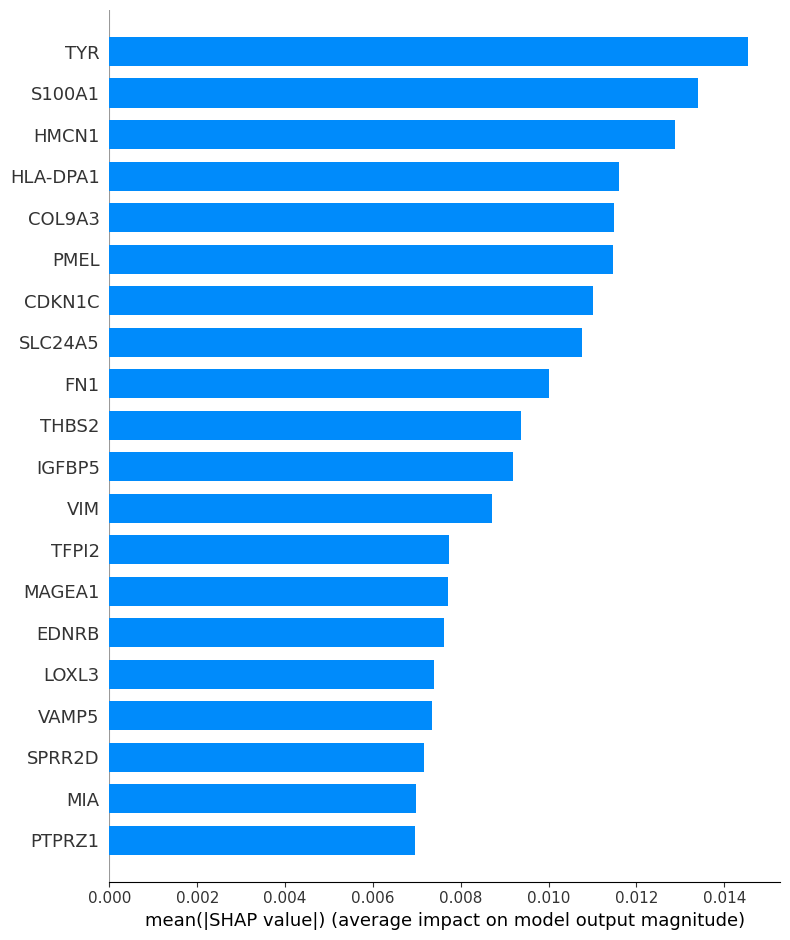

In [137]:
shap.summary_plot(shap_values[0:1,n_dim*2:], X_train[0:1,n_dim*2:], plot_type="bar", feature_names = adata.var_names)